In [1]:
! pip install datasets
! pip install tqdm

In [2]:
from reuters21578 import Reuters21578
import torch

! pip install transformers
from transformers import BertTokenizer, BertModel


c:\Users\Lenovo\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from reuters21578 import Reuters21578

# Create an instance of the dataset with a specific configuration
dataset = Reuters21578(config_name='ModApte')

# Download and prepare the dataset
dataset.download_and_prepare()

# Load the dataset
datasets = dataset.as_dataset()

# Access the train split
train_dataset = datasets['train']

# Print the labels for the first few examples
topics_count_dict = {}
for example in train_dataset:
    for topic in example['topics']:
        if topic not in topics_count_dict:
            topics_count_dict[topic] = 0
        topics_count_dict[topic] += 1

Repo card metadata block was not found. Setting CardData to empty.


In [4]:
print(len(train_dataset))

9603


In [5]:
for i in range(10):
    print(train_dataset[i]['topics'])

['cocoa']
['grain', 'wheat', 'corn', 'barley', 'oat', 'sorghum']
['veg-oil', 'linseed', 'lin-oil', 'soy-oil', 'sun-oil', 'soybean', 'oilseed', 'corn', 'sunseed', 'grain', 'sorghum', 'wheat']
[]
['earn']
['acq']
['earn']
['earn', 'acq']
['earn']
['earn']


In [8]:
print(train_dataset[1]['text'])

The U.S. Agriculture Department
reported the farmer-owned reserve national five-day average
price through February 25 as follows (Dlrs/Bu-Sorghum Cwt) -
         Natl   Loan           Release   Call
         Avge   Rate-X  Level    Price  Price
 Wheat   2.55   2.40       IV     4.65     --
                            V     4.65     --
                           VI     4.45     --
 Corn    1.35   1.92       IV     3.15   3.15
                            V     3.25     --
 X - 1986 Rates.

          Natl   Loan          Release   Call
          Avge   Rate-X  Level   Price  Price
 Oats     1.24   0.99        V    1.65    -- 
 Barley   n.a.   1.56       IV    2.55   2.55
                             V    2.65    -- 
 Sorghum  2.34   3.25-Y     IV    5.36   5.36
                             V    5.54    -- 
    Reserves I, II and III have matured. Level IV reflects
grain entered after Oct 6, 1981 for feedgrain and after July
23, 1981 for wheat. Level V wheat/barley after 5/14/82,
corn/sorg

In [68]:
# print top 10 topics

sorted_topics = sorted(topics_count_dict.items(), key=lambda x: x[1], reverse=True)
for i in range(100):
    print(sorted_topics[i])

('earn', 2877)
('acq', 1650)
('money-fx', 538)
('grain', 433)
('crude', 389)
('trade', 369)
('interest', 347)
('wheat', 212)
('ship', 197)
('corn', 182)
('money-supply', 140)
('dlr', 131)
('sugar', 126)
('oilseed', 124)
('coffee', 111)
('gnp', 101)
('gold', 94)
('veg-oil', 87)
('soybean', 78)
('livestock', 75)
('nat-gas', 75)
('bop', 75)
('cpi', 69)
('cocoa', 55)
('reserves', 55)
('carcass', 50)
('copper', 47)
('jobs', 46)
('yen', 45)
('ipi', 41)
('iron-steel', 40)
('cotton', 39)
('barley', 37)
('rubber', 37)
('gas', 37)
('rice', 35)
('alum', 35)
('meal-feed', 30)
('palm-oil', 30)
('sorghum', 24)
('retail', 23)
('silver', 21)
('zinc', 21)
('pet-chem', 20)
('wpi', 19)
('tin', 18)
('rapeseed', 18)
('stg', 17)
('housing', 16)
('strategic-metal', 16)
('hog', 16)
('orange', 16)
('lead', 15)
('soy-oil', 14)
('heat', 14)
('soy-meal', 13)
('fuel', 13)
('lei', 12)
('sunseed', 11)
('lumber', 10)
('dmk', 10)
('tea', 9)
('income', 9)
('oat', 8)
('nickel', 8)
('l-cattle', 6)
('sun-oil', 5)
('platin

In [78]:


# Load pre-trained model tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def split_doc_by_window(doc, window_size):
    # Initialize the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Tokenize the document
    tokens = tokenizer.tokenize(doc)
    chunks = []
    chunk = []
    current_chunk_size = 0

    for token in tokens:
        chunk.append(token)
        current_chunk_size += 1

        if token == '.' and current_chunk_size >= window_size:
            chunks.append(' '.join(chunk))
            chunk = []
            current_chunk_size = 0

    if len(chunk) > 0:
        chunks.append(' '.join(chunk))

    return chunks


def encode_chunks(chunks):
    encoding = tokenizer.batch_encode_plus( chunks,# List of input texts
    padding=True,              # Pad to the maximum sequence length
    truncation=True,           # Truncate to the maximum sequence length if necessary
    return_tensors='pt',      # Return PyTorch tensors
    add_special_tokens=True    # Add special tokens CLS and SEP
    )

    input_ids = encoding['input_ids']  # Tokenized and encoded sentences
    attention_mask = encoding['attention_mask']  # Attention mask

    # Generate embeddings using BERT model

    model = BertModel.from_pretrained('bert-base-uncased')

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        chunks_embedding = outputs.last_hidden_state.mean(dim=1)

    return chunks_embedding

def split_and_encode_doc(doc, window_size):
    chunks = split_doc_by_window(doc, window_size)
    chunks_embedding = encode_chunks(chunks)

    return chunks_embedding

def get_cos_sim_mat(embedding_1, embedding_2):
    cos_sim_matrix = embedding_1 @ embedding_2.T

    norm_1 = torch.norm(embedding_1, dim=1)
    norm_2 = torch.norm(embedding_2, dim=1)

    norm_mult_div = norm_1.reshape(-1, 1) @ norm_2.reshape(-1, 1).T

    cos_sim_matrix = cos_sim_matrix / norm_mult_div

    return cos_sim_matrix


windows = [10, 30, 50, 100, float('inf')]
doc_1 = train_dataset[1]['text']
doc_2 = train_dataset[2]['text']
for window in windows:
    chunks_embedding_1 = split_and_encode_doc(doc_1, window)
    chunks_embedding_2 = split_and_encode_doc(doc_2, window)

    cos_sim_matrix = get_cos_sim_mat(chunks_embedding_1, chunks_embedding_2)
    print(f'Window size: {window}, Cosine similarity mean: {cos_sim_matrix.mean()}, Cosine similarity max: {cos_sim_matrix.max()}')

Window size: 10, Cosine similarity mean: 0.7154720425605774, Cosine similarity max: 0.9022217988967896
Window size: 30, Cosine similarity mean: 0.7808124423027039, Cosine similarity max: 0.8669080138206482
Window size: 50, Cosine similarity mean: 0.7851669192314148, Cosine similarity max: 0.878635585308075
Window size: 100, Cosine similarity mean: 0.8139405846595764, Cosine similarity max: 0.9040043354034424
Window size: inf, Cosine similarity mean: 0.9119062423706055, Cosine similarity max: 0.9119062423706055


In [139]:
from sklearn.feature_extraction.text import TfidfVectorizer
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.cluster import KMeans
from tqdm import tqdm
import logging
import random

# Set up logging
logging.basicConfig(level=logging.INFO)


class Embedder:
    def __init__(self):
        pass

    def embed(self, chunks)->torch.Tensor:
        pass

class BertEmbedder(Embedder):
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = BertModel.from_pretrained('bert-base-uncased').to(self.device)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        print(f'BertEmbedder Using device: {self.device}')

    def embed(self, chunks):
        encodings = self.tokenizer.batch_encode_plus(chunks, padding=True, truncation=True, return_tensors='pt', add_special_tokens=True).to(self.device)
        input_ids = encodings['input_ids'].to(self.device)
        attention_mask = encodings['attention_mask'].to(self.device)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state.mean(dim=1)

        return embeddings.to('cpu')
    
class TFIDFEmbedder(Embedder):
    def __init__(self, corpus):
        self.vectorizer = TfidfVectorizer()
        self.vectorizer.fit(corpus)

    def embed(self, chunks):
        embeddings = self.vectorizer.transform(chunks).toarray()
        return torch.tensor(embeddings)
        
class CustomClusteringModel:

    coplase_types = ['mean', 'max', 'min', 'sum']
    weights_type = ['no_weights', 'inv_sqrt_len']

    def __init__(self, window_size):
        self.window_size = window_size
        self.embeddings_per_doc_list = [] # d:[[tf1, tf2,..],[bert1, bert2,..]]
        self.combined_embeddings_list = []
        self.labels = []

    def data(self, dataset):
        self.dataset = dataset
    
    # def fit(self, embbeders):
    #     for doc in tqdm(self.dataset, desc="Processing documents"):
    #         chunks = self._split_doc_by_window(doc['text'], self.window_size)
    #         embeddings_ = []

    #         if len(chunks) != 0: #somehow there are empty documents
    #             for embedder in embbeders:
    #                 embed = embedder.embed(chunks)
    #                 embeddings_.append(embed)

    #         self.embeddings_per_doc_list.append(embeddings_)
    #         self.labels.append(doc['topics'])

    def fit(self, embedders_dict):
        self.embbeders_to_idx = {embedder_name: idx for idx, embedder_name in enumerate(embedders_dict.keys())}
        embedders = list(embedders_dict.values())
        def _process_doc(doc):
            try:
                chunks = self._split_doc_by_window(doc['text'], self.window_size)
                embeddings_ = []

                if len(chunks) != 0:  # somehow there are empty documents
                    for embedder in embedders:
                        embed = embedder.embed(chunks)
                        embeddings_.append(embed)

                return embeddings_, doc['topics']
            except Exception as e:
                logging.error(f"Error processing document: {e}")
                return None, None

        with ThreadPoolExecutor() as executor:
            futures = [executor.submit(_process_doc, doc) for doc in self.dataset]
            for future in tqdm(as_completed(futures), total=len(futures), desc="Processing documents"):
                embeddings_, topics = future.result()
                self.embeddings_per_doc_list.append(embeddings_)
                self.labels.append(topics)
    
    def combine_embeddings_per_doc(self, weights_type='no_weights', colapse_type = None, embbeders_names=None):
        new_labels = []
        for embeddings_, label in zip(self.embeddings_per_doc_list, self.labels):
            if len(embeddings_) != 0: # remember that there are empty documents
                
                if embbeders_names is not None:
                    embeddings_ = [embeddings_[self.embbeders_to_idx[name]] for name in embbeders_names]
                # combine embeddings with weights
                if weights_type == 'no_weights':
                    if len(embeddings_) > 1:
                        combined_embedding = torch.cat(embeddings_, dim=1)
                elif weights_type == 'inv_sqrt_len':
                    if len(embeddings_) > 1:
                        combined_embedding = torch.cat([embeddings_[i] * self._inv_sqrt_len_weights(embeddings_) for i in range(len(embeddings_))], dim=1)
                    else:
                        combined_embedding = embeddings_[0]*self._inv_sqrt_len_weights(embeddings_)
                else:
                    raise ValueError(f'Weights type {weights_type} is not supported')

                # collapse embeddings
                if colapse_type == 'mean':
                    # print(combined_embedding.shape)
                    combined_embedding = combined_embedding.mean(dim=0)
                    # print(combined_embedding.shape)
                elif colapse_type == 'max':
                    combined_embedding = combined_embedding.max(dim=0).values
                elif colapse_type == 'min':
                    combined_embedding = combined_embedding.min(dim=0).values
                elif colapse_type == 'sum':
                    combined_embedding = combined_embedding.sum(dim=0)
                elif colapse_type is None:
                    pass
                else:
                    raise ValueError(f'Colapse type {colapse_type} is not supported')
                
                self.combined_embeddings_list.append(combined_embedding)
                new_labels.append(label)

        self.labels = new_labels
        
    def cluster(self, n, method='kmeans', rand_state=None):
        if method == 'kmeans':
            if rand_state is None:
                random_state = random.randint(0, 1000)
            else:
                random_state = rand_state
            print(f'Using random state: {random_state}')
            self.kmeans = KMeans(n_clusters=n, random_state=0).fit(self.combined_embeddings_list)
            return self.kmeans
        else:
            raise ValueError(f'Clustering method {method} is not supported')
    

    def _split_doc_by_window(self, doc, window_size):
        # Initialize the BERT tokenizer
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        # Tokenize the document
        tokens = tokenizer.tokenize(doc)
        chunks = []
        chunk = []
        current_chunk_size = 0

        for token in tokens:
            chunk.append(token)
            current_chunk_size += 1

            if token == '.' and current_chunk_size >= window_size:
                chunks.append(' '.join(chunk))
                chunk = []
                current_chunk_size = 0

        if len(chunk) > 0:
            chunks.append(' '.join(chunk))

        return chunks

    def _get_cos_sim_mat(self, embedding_1, embedding_2):
        cos_sim_matrix = embedding_1 @ embedding_2.T

        norm_1 = torch.norm(embedding_1, dim=1)
        norm_2 = torch.norm(embedding_2, dim=1)

        norm_mult_div = norm_1.reshape(-1, 1) @ norm_2.reshape(-1, 1).T

        cos_sim_matrix = cos_sim_matrix / norm_mult_div

        return cos_sim_matrix

    def _inv_sqrt_len_weights(self, embeddings):
        return 1/(len(embeddings[0])**0.5)

In [6]:
print(type(train_dataset))

<class 'datasets.arrow_dataset.Dataset'>


In [140]:
subset_dataset = train_dataset.select(range(1000))

train_corpus = [doc['text'] for doc in subset_dataset]

bert_embedder = BertEmbedder()
tfidf_embedder = TFIDFEmbedder(train_corpus)

embedders = {'tf-idf':tfidf_embedder, 'bert' :bert_embedder}

general_clustering_model = CustomClusteringModel(window_size=30)

general_clustering_model.data(subset_dataset)

general_clustering_model.fit(embedders)

BertEmbedder Using device: cuda


Processing documents: 100%|██████████| 1000/1000 [02:25<00:00,  6.89it/s]


In [142]:
general_clustering_model.combine_embeddings_per_doc(weights_type='inv_sqrt_len', colapse_type='mean', embbeders_names=['tf-idf'])

In [136]:
count = 0
count_9603 = 0
len_set = set()
for i in range(len(general_clustering_model.combined_embeddings_list)):
    if general_clustering_model.combined_embeddings_list[i].shape[0] != 9630:
        count+=1
    else:
        count_9603 +=1
    
    len_set.add(general_clustering_model.combined_embeddings_list[i].shape[0])

print(count)
print(count_9603)
print(len_set)
print(len(general_clustering_model.combined_embeddings_list))


940
0
{8862}
940


Using random state: 42
1823
883
75


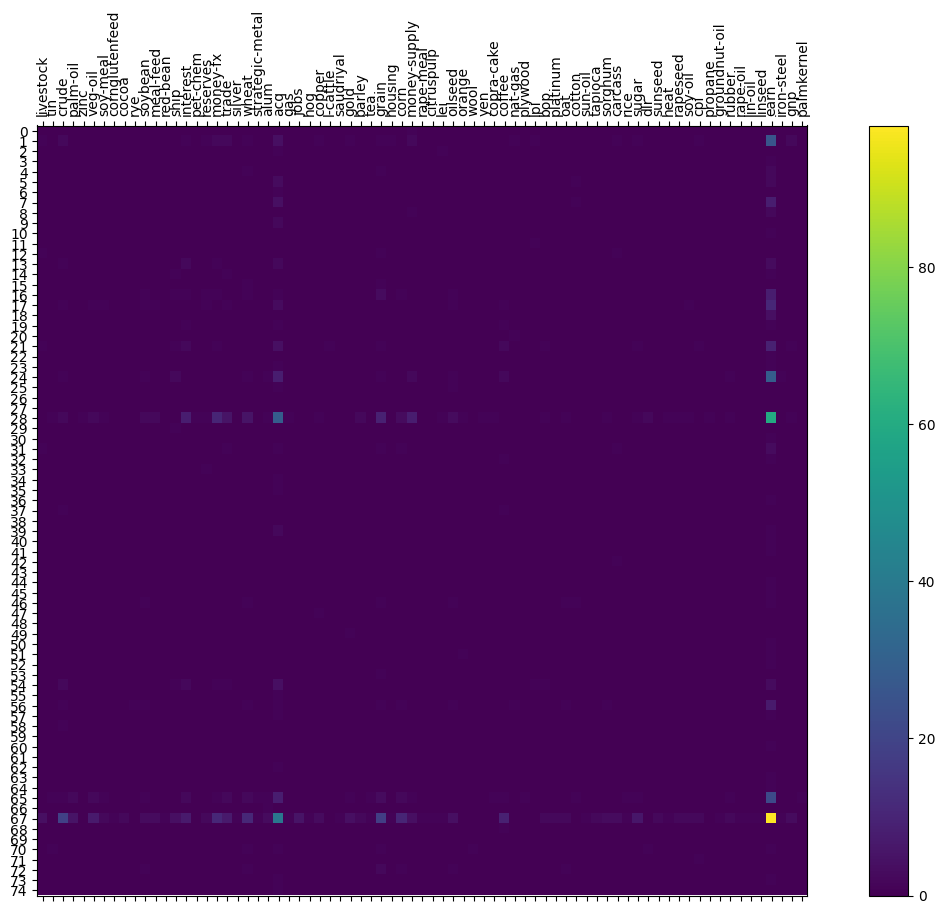

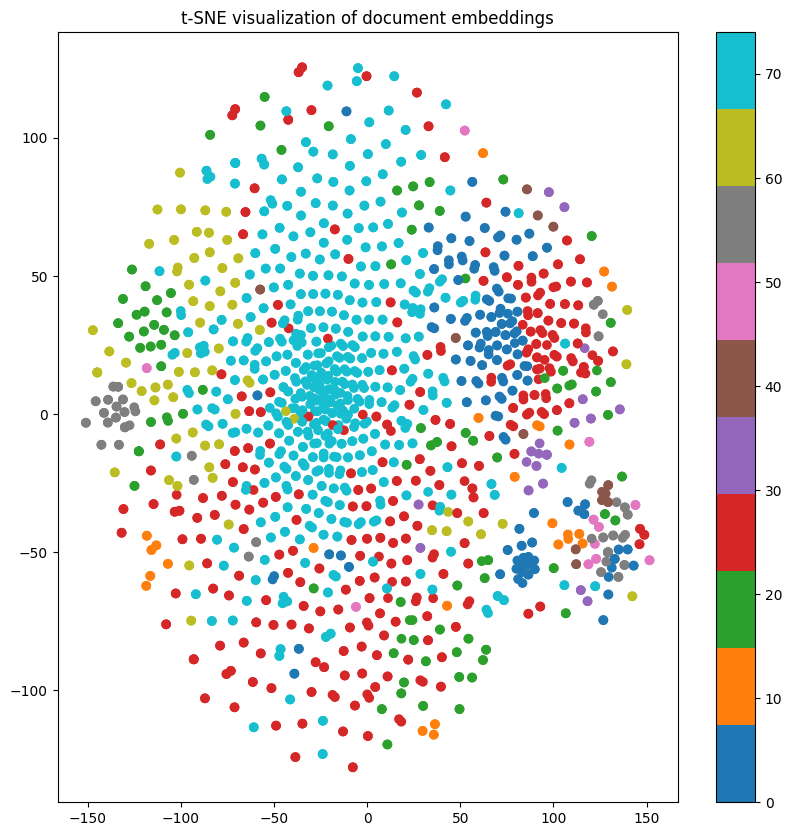

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Convert combined_embeddings_list to a NumPy array
combined_embeddings_array = np.array([embedding.numpy() for embedding in general_clustering_model.combined_embeddings_list])

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_embeddings = tsne.fit_transform(combined_embeddings_array)

all_topics = set(l for sublist in general_clustering_model.labels for l in sublist)

# Perform KMeans clustering
n = len(all_topics)
kmeans_model = general_clustering_model.cluster(n, rand_state=42)
kmeans_labels = kmeans_model.labels_

print(len(kmeans_model.labels_))
print(len(general_clustering_model.labels))
print(len(all_topics))


# topics statistics for each cluster
topic_to_index = {topic: i for i, topic in enumerate(all_topics)}
index_to_topic = {i: topic for i, topic in enumerate(all_topics)}

cluster_topic_counts = {i: {topic: 0 for topic in all_topics} for i in range(n)}
cluster_count = {i: 0 for i in range(n)}
for cluster_label, topics in zip(kmeans_labels, general_clustering_model.labels):
    for topic in topics:
        cluster_topic_counts[int(cluster_label)][topic] += 1
    cluster_count[int(cluster_label)] += 1


not_empty_clusters = [cluster for cluster, count in cluster_count.items() if count > 0]
cluster_topic_counts = {i: cluster_topic_counts[i] for i in not_empty_clusters}
fig, ax = plt.subplots(figsize=(16, 10))
cax = ax.matshow(np.array([list(cluster_topic_counts[i].values()) for i in not_empty_clusters], dtype=float), cmap='viridis')
fig.colorbar(cax)
ax.set_xticks(range(len(all_topics)))
ax.set_xticklabels(all_topics, rotation=90)
ax.set_yticks(range(n))
ax.set_yticklabels(range(n))
plt.title('Topics distribution for each cluster')
plt.show()

# Plot the t-SNE embeddings
plt.figure(figsize=(10, 10))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=kmeans_labels, cmap='tab10')
plt.colorbar()
plt.title('t-SNE visualization of document embeddings')
plt.show()